### 文本OCR模型 第2部分：CTPN模型学习
> CTPN是在ECCV 2016提出的一种文字检测算法。CTPN结合CNN与LSTM深度网络，能有效的检测出复杂场景的横向分布的文字

#### CTPN网络结构

![](assets/ctpn.jpg)

- feature map层：CTPN采用VGG16模型提取特征（也可以用其他模型），那么conv5 feature map的宽高都是输入Image的宽高的1/16
- RNN层：采用biLSTM双向RNN网络，文本是上下文链接的，RNN可以提升模型的准确度，同时也带来计算的代价。
- FC层：全连接层输出分类结果和目标框位置信息

#### anchor的设计（类似Faster R-CNN）
- CTPN针对的是横向排列的文字检测，所以其采用了一组10个**等宽度**的Anchors用于定位文字位置
- Anchors设计：
    1. 保证在x方向上，Anchor覆盖原图每个点且不相互重叠。
    2. 不同文本在y方向上高度差距很大，所以设置Anchors高度为11-283，用于覆盖不同高度的文本目标。
```
width = 16
heights=[11, 16, 23, 33, 48, 68, 97, 139, 198, 283]
```


![](assets/ctpn_1.jpg)

- 输出处理
1. Softmax判断Anchor中是否包含文本，即选出Softmax score大的正Anchor
2. Bounding box regression修正包含文本的Anchor的中心y坐标与高度。

#### CTPN Loss设计

![](assets/ctpn_2.png)

- Anchor Softmax loss：该Loss用于监督学习每个Anchor中是否包含文本。 
- Anchor y coord regression loss：该Loss用于监督学习每个包含为本的Anchor的Bouding box regression y方向offset，类似于Smooth L1 loss。其中 [公式] 是 [公式] 中判定为有文本的Anchor，或者与Groud truth vertical IoU>0.5。
- Anchor x coord regression loss：该Loss用于监督学习每个包含文本的Anchor的Bouding box regression x方向offset，与y方向同理。前两个Loss存在的必要性很明确，但这个Loss有何作用作者没有解释（从训练和测试的实际效果看，作用不大）

### 初始化模型

In [2]:
import config
from models import crnn_model, text_model
import sys
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image

net_text = text_model.TEXT_NET()
net_ocr = crnn_model.CRNN_NET()

cpu
loading weights:weights/text/text.pth Done
loading weights:weights/ocr/chinese/ocr_best.pth Done


In [38]:
print(net_text.net)

### 第二部分：CRNN模型学习

#### OCR CRNN识别的思路
> 把OCR转化成一个“特殊”的分类问题

![](assets/crnn.png)

#### 模型设计

![](assets/crnn_1.png)

#### OCR的特殊性
> OCR的“特殊性”在于label不定长，所以无法通过普通loss进行损失计算，需要使用CTCLoss

- CTC 的全称是Connectionist Temporal Classification. 这个方法主要是解决神经网络label 和output 不对齐的问题（Alignment problem）
- 非常适合语音识别或者OCR这种应用的。

#### darknet-ocr 的crnn简化版模型结构
- input ==> torch.Size([1, 1, 32, 462])

1. conv_1 
    - Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    - output ==> torch.Size([1, 64, 16, 231])

---

2. conv_2
    - Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    - output ==> torch.Size([1, 128, 8, 116])

---

3. conv_3
    - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, **stride=(2, 1)**, padding=0, dilation=1, **ceil_mode=True**)
    - output ==> torch.Size([1, 256, 4, 115])


---

3. conv_4
    - Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - ReLU()
    - MaxPool2d(kernel_size=2, **stride=(2, 1)**, padding=0, dilation=1, **ceil_mode=True**)

- output ==> torch.Size([1, 512, 2, 114])

---

4. conv_5
    - Conv2d(512, 512, kernel_size=(2, 2), stride=(1, 1))
    - ReLU()
    - output ==> torch.Size([1, 512, **1**, 113])

---

5. conv1x1_FC
    - Conv2d(512, 11316, kernel_size=(1, 1), stride=(1, 1))
    - output ==> torch.Size([1, **11316**, **1**, 113])

---

- output说明: [N, char_nums, h, w]


#### CRNN loss函数设计
```
criterion = CTCLoss(blank=len(alphabet)-1)
log_preds = torch.nn.functional.log_softmax(preds, dim=2)
preds_size = Variable(torch.IntTensor([log_preds.size(0)] * batch_size))
cost = criterion(log_preds, label_text, preds_size, label_lenght) / batch_size
```

loading weights:weights/ocr/chinese/ocr_best.pth Done
input ==> torch.Size([1, 1, 32, 462])
Sequential(
  (conv_0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_0): ReLU()
)
==> torch.Size([1, 64, 32, 462])
Sequential(
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
)
==> torch.Size([1, 64, 16, 231])
Sequential(
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_2): ReLU()
)
==> torch.Size([1, 128, 16, 231])
Sequential(
  (maxpool_3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
)
==> torch.Size([1, 128, 8, 116])
Sequential(
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_4): ReLU()
)
==> torch.Size([1, 256, 8, 116])
Sequential(
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (leaky_5): ReLU()
)
==> torch.Size([1, 256, 8, 116])
Sequential(
  (maxpool_6): MaxPool2d(kernel_size=2,

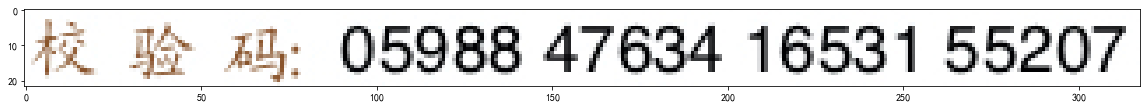

In [36]:
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from models.darknet_model import softmax
from models import crnn_model, text_model
import config

charactersPred, _ = config.get_characters()
def decode(pred):
        t = pred.argmax(axis=1)
        prob = [pred[ind, pb] for ind, pb in enumerate(t)]

        length = len(t)
        charList = []
        probList = []
        n = len(charactersPred)
        for i in range(length):
            if t[i] not in [n-1, n-1] and (not (i > 0 and t[i - 1] == t[i])):
                charList.append(charactersPred[t[i]])
                probList.append(prob[i])
        '''
        res = {'text': ''.join(charList),
               "prob": round(float(min(probList)), 2) if len(probList) > 0 else 0,
               "chars": [{'char': char, 'prob': round(float(p), 2)}for char, p in zip(charList, probList)]}
        '''
        res = {'text': ''.join(charList),
               "prob": float(min(probList)) if len(probList) > 0 else 0}
        return res

net_ocr = crnn_model.CRNN_NET()

### 1. 图片预处理
image = Image.open('test/dd.jpg').convert('L')
scale = image.size[1]*1.0 / 32
w = int(image.size[0] / scale)
image = image.resize((w, 32), Image.BILINEAR)
image = (np.array(image)/255.0-0.5)/0.5
h, w = image.shape
image = torch.tensor(image, dtype=torch.float).view(1, 1, h, w)

### 2. 模型预测
y_pred = image
print('input ==>', image.shape)
for name,m in net_ocr.net.module_list.named_children():
    y_pred = m(y_pred)
    print(m)
    print('==>', y_pred.shape)
#y_pred = net_ocr.net(image)

### 3. 后处理 & decode
out = y_pred[0][:, 0, :].detach().cpu().numpy()
out = out.transpose((1, 0))
out = softmax(out)
out = decode(out)
print(out)

image = Image.open('test/dd.jpg')
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.show()

In [39]:
import config
from models import crnn_model, text_model
import sys
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image

net_text = text_model.TEXT_NET()
net_ocr = crnn_model.CRNN_NET()

cpu
loading weights:weights/text/text.pth Done
loading weights:weights/ocr/chinese/ocr_best.pth Done


{'text': '迪孕期智商下线', 'prob': 1.0}


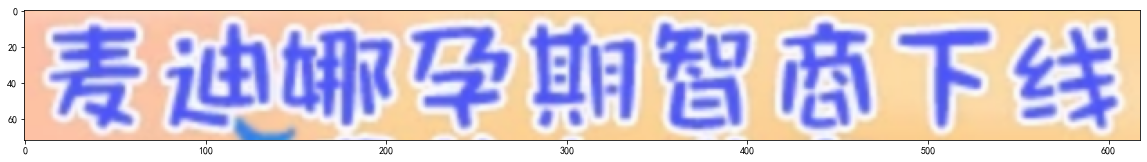

In [43]:
img = cv2.imread('test/ocr4.png')
img = Image.fromarray(img)
res = net_ocr.predict(img)
print(res)

plt.figure(figsize=(20,20))
plt.imshow(img)
plt.show()

迪普科技融资融券信息显示,2020年9月7日融资净偿还425.31万元;融资余额2.58亿元, [72, 113, 1348, 110, 1348, 158, 72, 159] 0.99
净买入(元) [1127, 521, 1324, 521, 1324, 572, 1127, 573] 0.98
2.58亿 [72, 584, 194, 583, 194, 627, 72, 627] 0.99
大盘调整如何把握逆势上涨机会?立即开户体验智买卖信号>> [96, 38, 906, 38, 906, 81, 96, 82] 0.99
-425.31万 [1173, 587, 1324, 578, 1327, 621, 1176, 630] 0.97
融资 [635, 463, 734, 460, 736, 507, 636, 510] 0.96
4.17 [366, 581, 466, 584, 464, 626, 365, 622] 0.96
1840.18万 [882, 581, 1054, 583, 1054, 627, 882, 626] 0.96
余额合计2.6亿元。 [0, 325, 293, 326, 293, 375, 0, 374] 0.98
余额占流通市值比例买入额( [243, 521, 808, 520, 808, 572, 243, 573] 0.96
较前一日下降1.62%。 [0, 161, 342, 161, 342, 205, 0, 205] 0.96
余额(元) [23, 523, 219, 521, 219, 570, 23, 572] 0.8
偿还额(元) [857, 521, 1078, 523, 1078, 570, 857, 570] 0.84
1414.87万 [636, 580, 808, 581, 808, 627, 636, 626] 0.91
迪普科技融资融券交易明细(09-07) [0, 397, 489, 395, 489, 438, 0, 440] 0.95
融券方面,融券卖出0股,融券偿还0股,融券余量2.33万股,融券余额104.31万元。融资融券 [0, 279, 1379, 279, 1379, 326, 0, 326] 0.98
融资方面,当日融资买入1414.87万元,融资偿还1840.18万

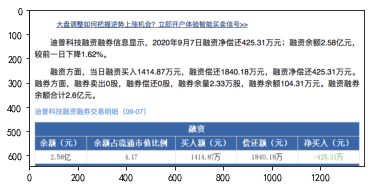

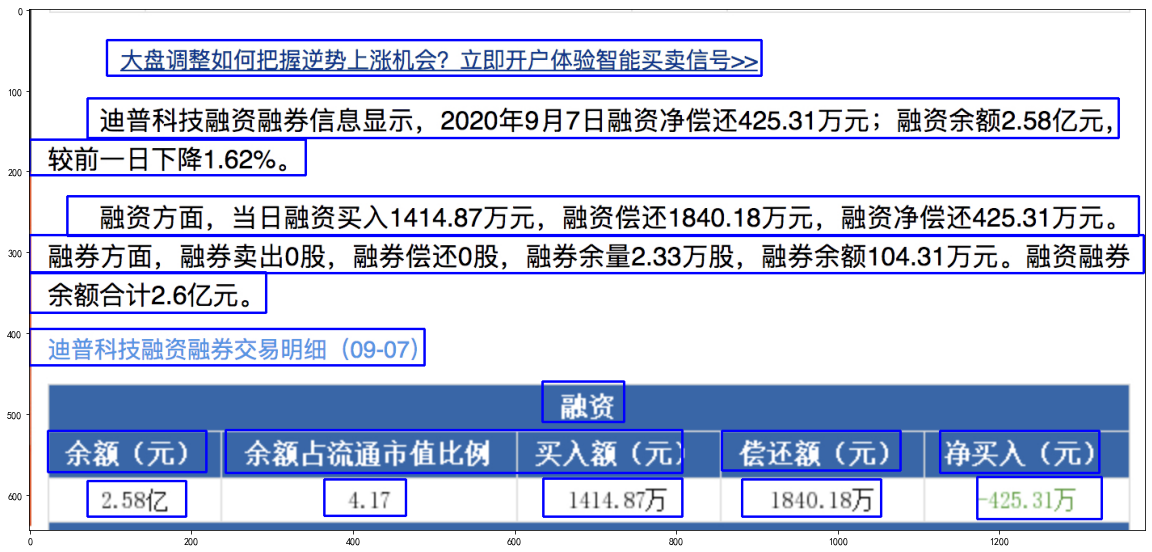

In [42]:

img = cv2.imread('test/demo_text_ocr.png')
plt.imshow(img[:,:,(2,1,0)])
boxes, scores = net_text.predict(img)

im = Image.fromarray(img)
result = []
for i, box in enumerate(boxes):
    if scores[i] > config.TEXT_LINE_SCORE:
            tmpImg = net_text.rotate_cut_img(
                im, box, leftAdjust=0.01, rightAdjust=0.01)
            text = net_ocr.predict(tmpImg)
            if text['text'] != '':
                text['box'] = [int(x) for x in box]
                text['textprob'] = round(float(scores[i]), 2)
                print(text['text'], text['box'], text['textprob'])
                result.append(text)
img_box = net_text.draw_boxes(img, boxes)
box_img_path = "test/pred_box.jpg"
cv2.imwrite(box_img_path, img_box)
plt.figure(figsize=(20,20))
plt.imshow(img_box[:,:,(2,1,0)])
plt.show()

#result = sorted(result, key=lambda x: sum(x['box'][1::2]))

In [10]:
import ocr_main
import cv2
ocr = ocr_main.OCR()

cpu
loading weights:weights/text/text.pth Done
loading weights:weights/ocr/chinese/ocr_best.pth Done


In [11]:
img = cv2.imread('test/dd.jpg')
res = ocr.predict_ocr(img)
print(res)

{'text': '校验码:05988476341653155207', 'prob': 1.0}


In [12]:
img = cv2.imread('test/demo_text_ocr.png')
boxes, scores = ocr.predict_text(img)
print(boxes.shape, scores.shape)

(17, 8) (17,)


In [13]:
import json
img = cv2.imread('test/demo_text_ocr.png')
res = ocr.predict(img, 'test/pred.jpg')
print(json.dumps(res,indent=4,ensure_ascii=False ))

[
    {
        "text": "大盘调整如何把握逆势上涨机会?立即开户体验智买卖信号>>",
        "prob": 1.0,
        "box": [
            96,
            38,
            906,
            38,
            906,
            81,
            96,
            82
        ],
        "textprob": 0.99
    },
    {
        "text": "迪普科技融资融券信息显示,2020年9月7日融资净偿还425.31万元;融资余额2.58亿元,",
        "prob": 1.0,
        "box": [
            47,
            113,
            1373,
            110,
            1373,
            158,
            47,
            159
        ],
        "textprob": 0.96
    },
    {
        "text": "较前一日下降1.62%。",
        "prob": 1.0,
        "box": [
            0,
            161,
            342,
            161,
            342,
            205,
            0,
            205
        ],
        "textprob": 0.97
    },
    {
        "text": "融资方面,当日融资买入1414.87万元,融资偿还1840.18万元,融资净偿还425.31万元。",
        "prob": 1.0,
        "box": [
            47,
            231,
            1373,
            231,
            13